In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import cartopy.crs as ccrs
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from pyfonts import set_default_font, load_google_font

Followed [documentation](https://residentmario.github.io/geoplot/plot_references/plot_reference.html#cartogram) 

In [2]:
frogID_data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-02/frogID_data.csv")
frog_names = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-02/frog_names.csv")

In [3]:
au = gpd.read_file("australian-states.json")
au

,STATE_CODE,STATE_NAME,geometry
0,1,New South Wales,"POLYGON ((149.97668 -37.50506, 148.19495 -36.7..."
1,2,Victoria,"POLYGON ((140.96574 -38.05599, 140.96362 -33.9..."
2,3,Queensland,"MULTIPOLYGON (((153.47693 -28.15702, 153.10883..."
3,4,South Australia,"MULTIPOLYGON (((129.00134 -31.68707, 129.00185..."
4,5,Western Australia,"POLYGON ((129.00124 -14.87947, 129.00134 -31.6..."
5,6,Tasmania,"MULTIPOLYGON (((144.75446 -41.06182, 144.68604..."
6,7,Northern Territory,"MULTIPOLYGON (((138.00118 -16.54451, 137.99905..."
7,8,Australian Capital Territory,"POLYGON ((149.39928 -35.31918, 149.35213 -35.3..."


In [4]:
# Merge frogID_data and frog_names
frogs = pd.merge(frogID_data, frog_names, on="scientificName", how="left")

In [5]:
# Fill na values
frogs = frogs.fillna("Uncategorized")

In [6]:
# Replace values to match the json file
frogs = frogs.replace(to_replace="Other Territories", value="Australian Capital Territory")
frogs.head(2)

,occurrenceID,eventID,decimalLatitude,decimalLongitude,scientificName,eventDate,eventTime,timezone,coordinateUncertaintyInMeters,recordedBy,stateProvince,subfamily,tribe,commonName,secondary_commonNames
0,12832,525618,-28.5,153.1,Philoria loveridgei,2023-01-01,11:18:32,GMT+1100,10000.0,41480,New South Wales,Myobatrachid,Limnodynastidae,Masked Mountain Frog,Loveridge’s Mountain Frog
1,12833,526341,-33.7,151.2,Heleioporus australiacus,2023-01-02,20:39:30,GMT+1100,10000.0,834983,New South Wales,Uncategorized,Uncategorized,Uncategorized,Uncategorized


In [7]:
# Convert date to datetime
frogs["date"] = pd.to_datetime(frogs["eventDate"])

In [8]:
# Australia has four distinct seasons: summer (December to February), autumn (March to May), winter (June to August), and spring (September to November). 
# Function to assign season based on the month
def assign_season(date):
    if date.month in [12, 1, 2]:
        return "Summer"
    elif date.month in [3, 4, 5]:
        return "Autumn"
    elif date.month in [6, 7, 8]:
        return "Winter"
    elif date.month in [9, 10, 11]:
        return "Spring"

frogs["season"] = frogs["date"].apply(assign_season)
frogs.head(2)

,occurrenceID,eventID,decimalLatitude,decimalLongitude,scientificName,eventDate,eventTime,timezone,coordinateUncertaintyInMeters,recordedBy,stateProvince,subfamily,tribe,commonName,secondary_commonNames,date,season
0,12832,525618,-28.5,153.1,Philoria loveridgei,2023-01-01,11:18:32,GMT+1100,10000.0,41480,New South Wales,Myobatrachid,Limnodynastidae,Masked Mountain Frog,Loveridge’s Mountain Frog,2023-01-01,Summer
1,12833,526341,-33.7,151.2,Heleioporus australiacus,2023-01-02,20:39:30,GMT+1100,10000.0,834983,New South Wales,Uncategorized,Uncategorized,Uncategorized,Uncategorized,2023-01-02,Summer


In [9]:
# Create a count df
frogs_count = frogs.groupby(["stateProvince", "season"])["season"].value_counts().reset_index()
frogs_count.head(2)

,stateProvince,season,count
0,Australian Capital Territory,Autumn,341
1,Australian Capital Territory,Spring,1022


In [10]:
# Create a df with mean lon, lat
frogs_loc = frogs.groupby(["stateProvince", "season"])[["decimalLatitude", "decimalLongitude"]].mean().reset_index()
frogs_loc.head(2)

,stateProvince,season,decimalLatitude,decimalLongitude
0,Australian Capital Territory,Autumn,-35.265067,149.352519
1,Australian Capital Territory,Spring,-35.282666,149.177836


In [11]:
# Merge count and loc df
frogs_agg = pd.merge(frogs_count, frogs_loc, on=["stateProvince", "season"])
frogs_agg.head(2)

,stateProvince,season,count,decimalLatitude,decimalLongitude
0,Australian Capital Territory,Autumn,341,-35.265067,149.352519
1,Australian Capital Territory,Spring,1022,-35.282666,149.177836


In [12]:
# Create new df to subplot title
totals = frogs.season.value_counts().reset_index()
totals

,season,count
0,Spring,60791
1,Winter,32174
2,Summer,25653
3,Autumn,18007


In [13]:
# Join df with au json based on index
result = au.set_index("STATE_NAME").join(frogs_agg.set_index("stateProvince"))
result.head(2)

,STATE_CODE,geometry,season,count,decimalLatitude,decimalLongitude
STATE_NAME,,,,,,
New South Wales,1,"POLYGON ((149.97668 -37.50506, 148.19495 -36.7...",Autumn,7894,-33.037124,151.139456
New South Wales,1,"POLYGON ((149.97668 -37.50506, 148.19495 -36.7...",Spring,28959,-32.926397,151.157144


In [14]:
# Load font
font = load_google_font("Chango")
# Sets font for all text
set_default_font(font) 

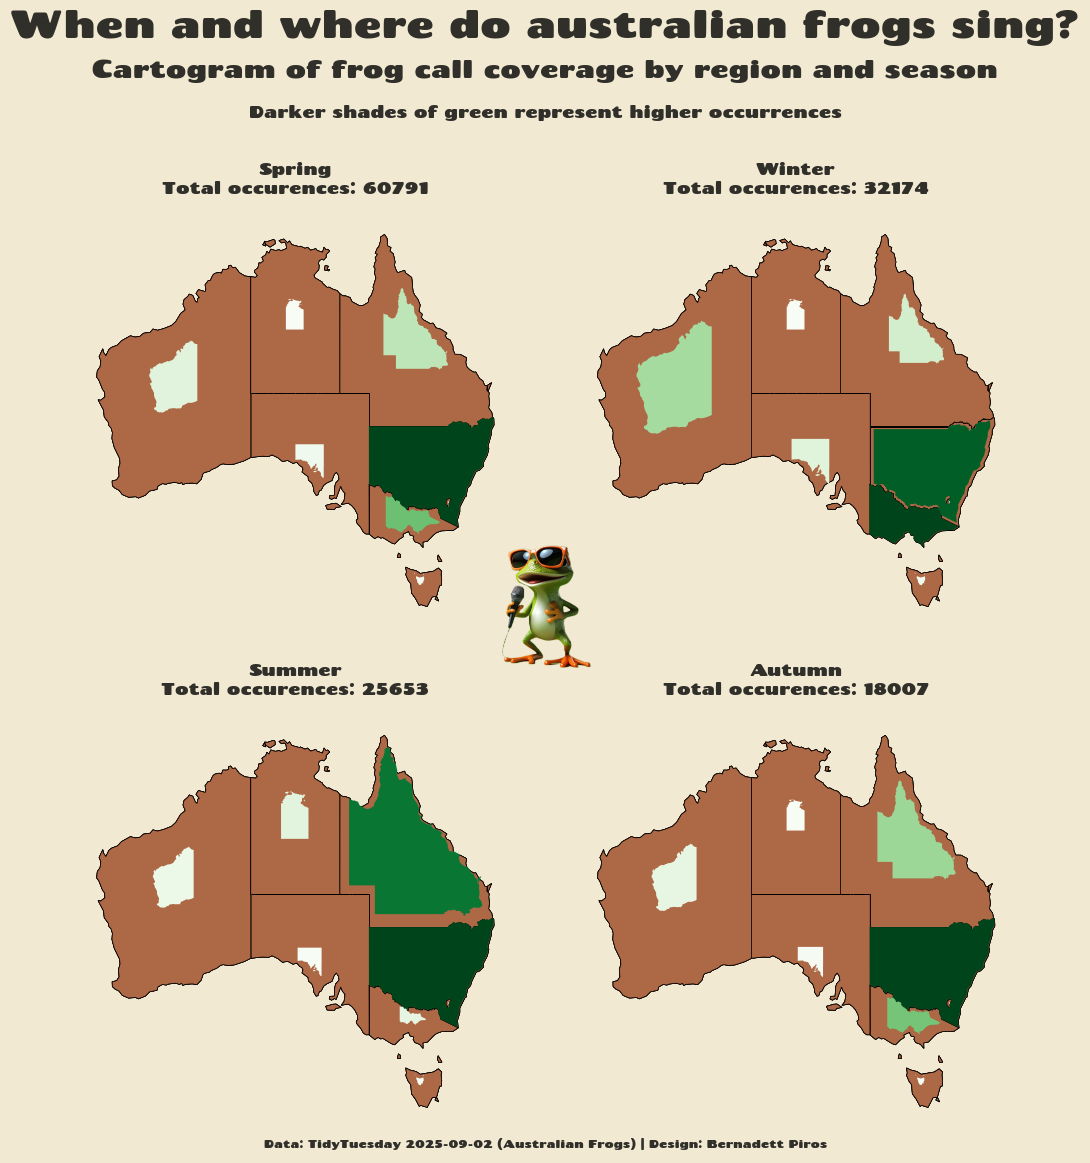

In [15]:
# Get the unique season values 
seasons = totals["season"].unique()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True,
                         subplot_kw={"projection": ccrs.Mercator()})  # Cartopy Mercator projection
# Flatten axes to make indexing easier
axs = axs.flatten()  

# Iterate over totals df's rows 
for idx, (i, row) in enumerate(totals.iterrows()):
    season = row["season"]  
    total_count = row["count"]  

    # Select the subplot axis
    ax = axs[idx]  
    
    # Filter the gdf by season
    season_gdf = result[result["season"] == season]  
    
    # Plot cartogram for each season
    gplt.cartogram(season_gdf, scale="count", hue="count", cmap="Greens", projection=gcrs.Mercator(), ax=ax, legend=False)
    
    # Subplot titles
    ax.set_title(f'{season}\nTotal occurences: {total_count}', alpha=0.8,)

    # Subplot background color
    ax.set_facecolor("#F1E9D2")
    
    # Plot au boundary 
    gplt.polyplot(result, facecolor='#AD6846', edgecolor="black", lw=0.5, ax=ax)

## Child axis
# Add an inset axis at the center of the figure
inset_ax = fig.add_axes([0.45, 0.45, 0.1, 0.2])  
inset_ax.set_facecolor("#F1E9D2")

# Load frog image
image = Image.open("frogy.png")
# Convert image to a np array 
image_np = np.array(image)
# Plot image in the inset axis
inset_ax.imshow(image)
# Remove inset_ax axis
inset_ax.axis("off")

## Texts
fig.text(0.5, 1.12, "When and where do australian frogs sing?", size=27, weight="bold", alpha=0.8, ha="center")

fig.text(0.5, 1.08, "Cartogram of frog call coverage by region and season", size=18, weight="bold", alpha=0.8, ha="center")

fig.text(0.5, 1.04, "Darker shades of green represent higher occurrences", size=12, alpha=0.8, ha="center")

fig.text(0.5, 0.01, "Data: TidyTuesday 2025-09-02 (Australian Frogs) | Design: Bernadett Piros", size=8, alpha=0.8, ha="center")

# Figure background color
fig.set_facecolor("#F1E9D2")

plt.show()

#fig.savefig("2025-09-02.png", bbox_inches='tight', pad_inches=0.2)